In [1]:
from matplotlib import image
import matplotlib.pyplot as plt
import numpy as np
import torch
import numpy 

%load_ext autoreload
%autoreload 2
torch.manual_seed(0)

from IPython.display import clear_output 
clear_output(wait = True)
import sys 
sys.path.append('..\..\..')
from models import DIFDensityEstimator,EMDensityEstimator
from utils.color_visual import *
import pickle

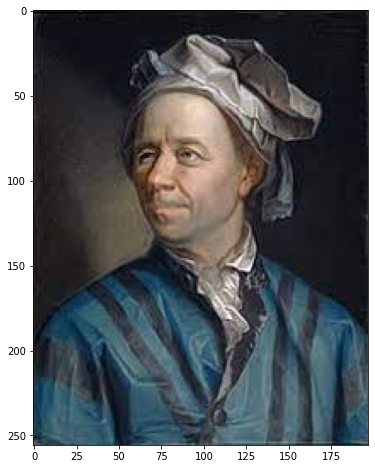

In [2]:
rgb = image.imread("euler.jpg")
figure = plt.figure(figsize = (12,8))
plt.imshow(rgb)
lines, columns = rgb.shape[:-1]

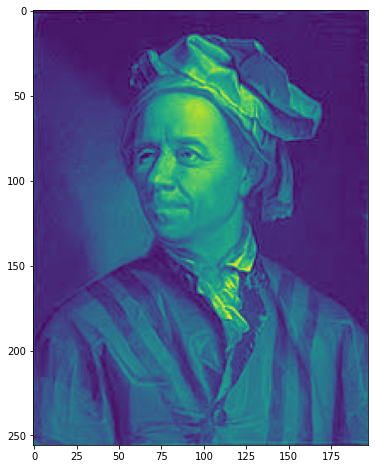

In [3]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
grey = torch.tensor(rgb2gray(rgb))
figure = plt.figure(figsize = (12,8))
plt.imshow(grey)

In [4]:
filename = 'euler_samples.sav'
target_samples = pickle.load(open(filename,'rb'))

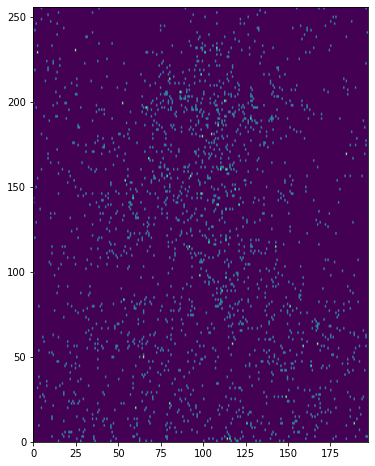

In [5]:
hist_target_samples, x_edges, y_edges = numpy.histogram2d(target_samples[:,1].numpy(), target_samples[:, 0].numpy(), bins = (lines, columns))
figure = plt.figure(figsize = (12,8))
plt.imshow(torch.flip(torch.flip(torch.tensor(hist_target_samples).T,[0,1]),[0,1]),extent = [0,columns,0, lines])

In [7]:
filename = 'euler_em.sav'
EM = pickle.load(open(filename,'rb'))
grid = torch.cartesian_prod(torch.linspace(0,lines,lines),torch.linspace(0,columns, columns))
density = torch.exp(EM.log_density(grid)).reshape(lines,columns).T.cpu().detach()
figure = plt.figure(figsize = (12,8))
plt.imshow(torch.flip(torch.flip(density.T,[0,1]),[0,1]),extent = [0,columns,0, lines])
EM_samples = EM.sample_model(target_samples.shape[0])
hist_EM_samples, x_edges, y_edges = numpy.histogram2d(EM_samples[:,1].numpy(), EM_samples[:, 0].numpy(), bins = (lines, columns))
figure = plt.figure(figsize = (12,8))
plt.imshow(torch.flip(torch.flip(torch.tensor(hist_EM_samples).T,[0,1]),[0,1]),extent = [0,columns,0, lines])

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [ ]:
filename = 'euler_dif.sav'
dif = pickle.load(open(filename,'rb'))
grid = torch.cartesian_prod(torch.linspace(0,lines,lignes),torch.linspace(0,columns, columns))
density = torch.exp(dif.log_density(grid)).reshape(lines,columns).T.cpu().detach()
figure = plt.figure(figsize = (12,8))
plt.imshow(torch.flip(torch.flip(density.T,[0,1]),[0,1]),extent = [0,columns,0, lines])
dif_samples = dif.sample_model(target_samples.shape[0])
hist_dif_samples, x_edges, y_edges = numpy.histogram2d(dif_samples[:,1].numpy(), dif_samples[:, 0].numpy(), bins = (lines, columns))
figure = plt.figure(figsize = (12,8))
plt.imshow(torch.flip(torch.flip(torch.tensor(hist_dif_samples).T,[0,1]),[0,1]),extent = [0,columns,0, lines])